In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform = transforms.ToTensor()

In [5]:
train_set = datasets.MNIST(root='./Data',train=True, download=True, transform=transform)

In [6]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
test_set = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [8]:
test_set

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [9]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

In [10]:
class CNN(nn.Module):
    """
        Creating CNN architecture
        
        2 convolutional layers and 3 fully connected layers
    
        
    """
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1) # 1 input channel (grayscale img), 6 image filters,kernel 3(3x3 filter), stride 1
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [11]:
torch.manual_seed(42)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
for param in model.parameters():
    print(param.numel())  # total 60074 params in total

54
6
864
16
48000
120
10080
84
840
10


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
import time
start_time = time.time()

epochs = 8

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X_train here
        loss = criterion(y_pred, y_train)
 
        # Number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Printing results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
     
    # Update train loss and accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    # Update test loss and accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.22537120  accuracy:  78.450%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.53863007  accuracy:  85.575%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.03859486  accuracy:  88.672%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01826747  accuracy:  90.463%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00651854  accuracy:  91.607%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.01039703  accuracy:  92.428%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.04001389  accuracy:  93.033%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00153118  accuracy:  93.560%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00019063  accuracy:  93.993%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00061045  accuracy:  94.335%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.07899837  accuracy:  97.967%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.18192156  accuracy:  97.900%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.19101562  accuracy:  97.922%
epoch:  1  b

In [27]:
# Visualizing losses

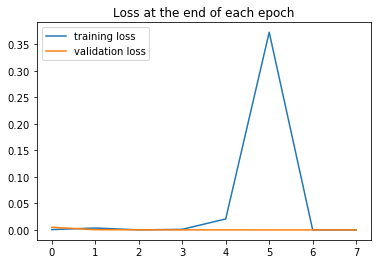

In [15]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [26]:
# Test data evaluation

In [16]:
print(test_correct)
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9807), tensor(9810), tensor(9833), tensor(9864), tensor(9846), tensor(9869), tensor(9867), tensor(9843)]

Test accuracy: 98.430%


In [21]:
test_load_all = DataLoader(test_set, batch_size=10000, shuffle=False)

In [24]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_set)} = {correct.item()*100/(len(test_set)):7.3f}%')

Test accuracy: 9843/10000 =  98.430%


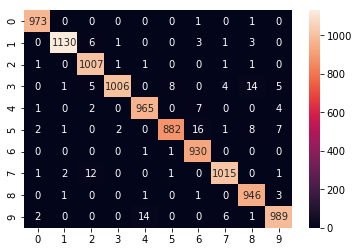

In [25]:
import seaborn as sns
cf_matrix = confusion_matrix(predicted.view(-1), y_test.view(-1)) # view(-1) so it fits for cf matrix visaulization
sns.heatmap(cf_matrix, annot=True,fmt='g')